In [61]:
import numpy as np

import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, VarianceThreshold

In [ ]:
# Create a function for performing feature selection using the filter method with sklearn

In [54]:
def remove_outliers(X):
    # Use the Interquartile Range (IQR) to remove outliers
    Q1 = np.quantile(X, 0.25, axis=0)
    Q3 = np.quantile(X, 0.75, axis=0)
    IQR = Q3 - Q1
    X = X[~((X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))).any(axis=1)]
    return X

def pearson_correlation(x, y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    num = np.sum((x - x_mean) * (y - y_mean))
    den = np.sqrt(np.sum((x - x_mean)**2) * np.sum((y - y_mean)**2))
    return num / den

def pearson_correlation_matrix(X):
    n_features = X.shape[1]
    correlation_matrix = np.zeros((n_features, n_features))

    for i in range(n_features):
        for j in range(n_features):
            correlation_matrix[i, j] = pearson_correlation(X[:, i], X[:, j])

    # Create a heatmap using Matplotlib
    fig, ax = plt.subplots()
    cax = ax.imshow(correlation_matrix, cmap='PuOr', vmin=-1, vmax=1, origin='lower')

    # Add correlation coefficients to each cell
    for i in range(n_features):
        for j in range(n_features):
            value = round(correlation_matrix[i, j], 2)
            ax.text(j, i, value, ha='center', va='center', color='black' if -0.5 < value < 0.5 else 'white')


    # Set plot title and labels
    ax.set_title("Pearson Correlation Matrix")
    ax.set_xlabel("Feature Index")
    ax.set_ylabel("Feature Index")
    ax.set_xticks(range(n_features))
    ax.set_yticks(range(n_features))

    # Add colorbar
    cbar = fig.colorbar(cax, ticks=[-1, 0, 1])
    cbar.set_label('Correlation Coefficient')

    # Show the plot
    plt.show()

## Star Dataset Pre-processing

#### Load the Star Dataset

In [ ]:
star_file_name = 'datasets/star_assessment.csv'
star_features = np.genfromtxt(star_file_name, delimiter=',', skip_header=True, encoding="utf-8", usecols=range(0, 17))
star_labels = np.genfromtxt(star_file_name, delimiter=',', skip_header=True, encoding="utf-8", usecols=17, dtype=None)

In [ ]:
# Explore the star dataset
print(f'Number of samples: {star_features.shape[0]}')
print(f'Number of features: {star_features.shape[1]-1}')
print(f'Number of classes: {np.unique(star_labels).shape[0]}')
print(f'Class names: {np.unique(star_labels)}')

#### Filling in Missing Values

In [ ]:
# Count the number of missing values in each column
missing_vals = np.sum(np.isnan(star_features), axis=0)
for k, v in enumerate(missing_vals):
    print(f'Column {k+1}: {v} missing values')
print(f'Total: {sum(missing_vals)} missing values')

In [ ]:
# Use a KNN imputer to fill in the missing values
knn_imputer = KNNImputer()
star_features_imputed = knn_imputer.fit_transform(star_features)

#### Encoding the Class Labels

In [ ]:
# Encode the class labels
label_encoder = LabelEncoder()
star_labels_encoded = label_encoder.fit_transform(star_labels)

#### Removing Samples with Outliers

In [55]:
star_features_no_outliers = remove_outliers(star_features_imputed)

print(f'Number of samples: {star_features_no_outliers.shape[0]}')

Number of samples: 85613


#### Feature Selection Using the Filter Method

In [56]:
# First use a variance threshold to remove any features with zero variance
threshold = 0
variance_threshold = VarianceThreshold(threshold=threshold)
star_features_imputed = variance_threshold.fit_transform(star_features_imputed)

In this case, the `rerun_ID` feature has zero variance, so it is removed.

In [64]:
# Then use the f_classif method to determine the correlation between each feature and the class labels
select_k_best = SelectKBest()
_ = select_k_best.fit_transform(star_features_imputed, star_labels_encoded)

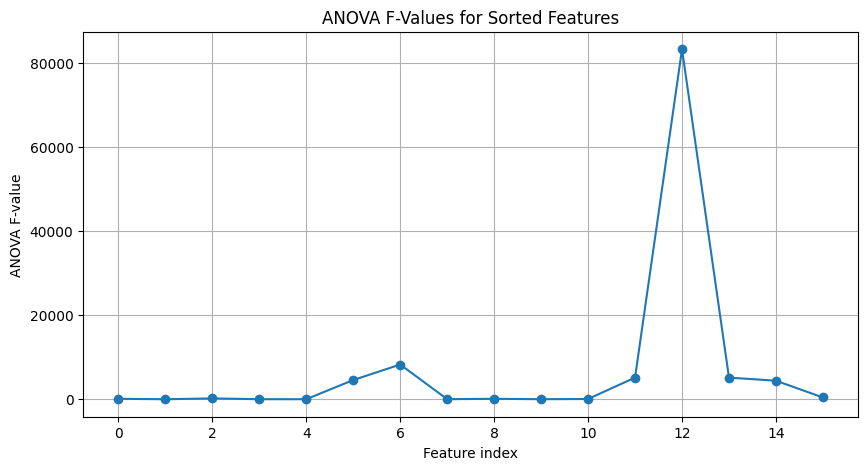

In [65]:
# Plot the sorted ANOVA F-values
plt.figure(figsize=(10, 5))
plt.plot(select_k_best.scores_, marker='o')
plt.xlabel('Feature index')
plt.ylabel('ANOVA F-value')
plt.title('ANOVA F-Values for Sorted Features')
plt.grid(True)

# Display the plot
plt.show()

Based on the plot above, we can see that the features with index 5 (`r`), 6 (`i`), 11 (`spec_obj_ID`), 12 (`redshift`), 13 (`plate`), and 14 (`MJD`) have significantly higher ANOVA F-values than the other features, thus they have a stronger influence on the target. Additionally, the upon further investigation into what each column represents through visiting [Kaggle](https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17), seemingly the features with index 3 (`u`), 4 (`g`), and 7 (`z`) may also be important as they represent the different filters used in the photometric system, similar to the features with index 5 (`r`) and 6 (`i`).

Therefore, the features that will be dropped are:
- `obj_ID`: given that it is just an identifier, it does not provide any useful information for classification and would only add noise to the model.
- `alpha`: this feature represents the right ascension of the object, which is a coordinate used to locate objects in the sky. It shouldn't provide any benefit to the model in the classification of an object as a star, galaxy, or quasar as they are distributed across the sky.
- `delta`: similar to `alpha`, this column represents the declination of the object, which is a coordinate for locating objects. It also shouldn't provide any benefit to the model.
- `run_ID`: this feature refers to a specific scan of the sky, which is an identifier for the run that the object was observed in. It shouldn't provide any benefit to the model as it isn't related to the detection of an object as a star, galaxy, or quasar.
- `cam_col`: this feature represents the camera column used during the observation. Like the `run_ID`, it is not related to the object's properties thus is less relevant to the classification task.
- `field_ID`: this feature represents the field number of the observation. It is also not related to the object's properties so shouldn't be relevant to the classification task.
- `fiber_ID`: this refers to the fiber number used to capture the spectrum of the object. The feature is not related to the object's properties so won't provide any benefit to the model.

In [59]:
# Drop the features as described above
star_features_selected = np.delete(star_features_imputed, [0, 1, 2, 8, 9, 10, 15], axis=1)

# Print the shape of the new feature matrix
print(f'Number of samples: {star_features_selected.shape[0]}')
print(f'Number of features: {star_features_selected.shape[1]}')

Number of samples: 100000
Number of features: 9


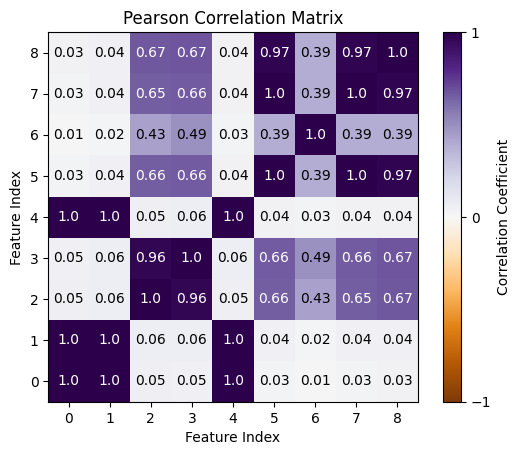

In [60]:
pearson_correlation_matrix(star_features_selected)

From this matrix, it is clear that the following features are highly correlated:
- 0 (`u`), 1 (`g`) and 4 (`z`)
- 2 (`r`) and 3 (`i`)
- 5 (`spec_obj_ID`), 7 (`plate`) and 8 (`MJD`)

It makes sense that several of the features related to the photometric system are correlated as they represent the intensity of the object's light at different wavelengths. Since objects emit light across a range of wavelengths, it is expected that the light will be correlated across the different filters.

### GWP Dataset Pre-processing

In [ ]:
gwp_file_name = 'datasets/gwp_assessment.csv'
gwp_strings = np.genfromtxt(gwp_file_name, delimiter=',', skip_header=True, encoding="utf-8", dtype=str, usecols=range(0, 4))
gwp_floats = np.genfromtxt(gwp_file_name, delimiter=',', skip_header=True, encoding="utf-8", dtype=np.float64, usecols=range(4, 14))
gwp_values = np.genfromtxt(gwp_file_name, delimiter=',', skip_header=True, encoding="utf-8", dtype=np.float64, usecols=14)

In [ ]:
# Explore the gwp dataset
print(f'Number of samples: {gwp_strings.shape[0]}')
print(f'Number of features: {gwp_strings.shape[1] + gwp_floats.shape[1]}')

In [ ]:
# Count the number of missing values in each column
missing_string_vals = np.sum(np.char.strip(gwp_strings) == '', axis=0)
missing_float_vals = np.sum(np.isnan(gwp_floats), axis=0)
missing_vals = np.concatenate((missing_string_vals, missing_float_vals))
for k, v in enumerate(missing_vals):
    print(f'Column {k+1}: {v} missing values')
print(f'Total: {sum(missing_vals)} missing values')